# 03 Support Vector Machines

In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report, accuracy_score

In this notebook, the only code that should to change are in the parameters dictionaries called `params`.

Along with the other packages used in this course, this notebook requires the following packages:
- pandas
- ucimlrepo
- sklearn

Some sections of the notebook call functions from earlier sections, thus running out of order could lead to `NameErrors` being raised.

# Machine Learning Fundamentals

Machine learning is a collection of algorithms that learn patterns from data and make predictions or decisions without being explicitly programmed for specific tasks. Rather than hard-coding instructions, these algorithms infer rules and structures directly from data, often guided by optimization objectives.

Common types of machine learning algorithms are:
- Classification: The task of assigning input data to one of several predefined categories. Example: Given a picture, determine if an image is a cat, dog, or frog.
- Clustering: The task of identifying natural groupings in data without using labels. Example: Given a bunch of pictures group similar images together.
- Regression: The task of predicting continuous outputs based on input features. Example: Given historical temperature data and time of year, predict the temperature on a future date.
- Reinforcement Learning: Involves learning optimal action through trial and error in an environment and receiving feedback in the form of rewards or penalties. Example: Teaching an AI to play tetris by rewarding longer survival and higher scores.

If we define a piece of data as:
$$
\textbf{x} = \begin{bmatrix}
x_0&&x_1&&\cdot\cdot\cdot&&x_n\\
\end{bmatrix}^{T}
$$
Then, each $x_i$ is called a feature. Features can take on continuous or categorical (discrete) values. If we let $\mathbf{x} \in \mathbb{R}^n$ represent a feature vector. Each $\mathbf{x}$ is associated with a class label $y \in \mathbf{Y}$, where $\mathbf{Y} = {1, 2, \dots, K}$ for a $K$-class classification problem.

## Machine Learning Pipeline

![My Image](imgs/03-A-fig1.png)

## Support Vector Machines

### Linear SVM
Support Vector Machines (SVM) is a machine learning algorithm used primarily for classification. Its main goal is to find the best separating hyperplane between different classes of data.

Assume we have two linearly separable classes (meaning there exists a linear hyperplane that perfectly separates both classes).
As shown in the figure below, there are infinitely many hyperplanes that can separate the two classes.

However, SVM always select the hyperplane that **maximizes the margin** $\gamma$, which is the distance between the hyperplane and the closest data points from each class, known as **support vectors**.

This leads to better generalization on unseen data and less prone to overfitting to either class.

![My Image](imgs/03-A-fig2.png)

However, simply maximizing $\gamma$ can still lead to overfitting in our data; thus we introduce a regularization term to our algorithm to help lower the chances of overfitting. This regularization term helps generalize our model by preventing it from fitting noise or outliers too closely. The tradeoff between minimizing our error (loss) and regularization is governed by the hyperparameter $C$.

To train SVM, we will try to minimize the following:
$$
J(\textbf{w}, b) = \text{min regularization} + C * \text{loss}\tag{1}
$$
where b is some bias.

For SVM, it is common to use a $l_2$ regularizer and a hinge loss. An $l_2$ regularizer is $\textbf{w}^{T} \textbf{w}$ and a hinge loss is $\text{max}(1-y_i\textbf{w}^T\textbf{x}_i+b, 0)$. The regularizer term penalizes large weights and encourages a simpler, more generalizable model. This loss fuction is zero when the point is correctly classified within the margin, and it grows linearly as the point moves closer to or crosses the margin boundary. A visualization of the hinge loss can be seen below.

![My Image](imgs/03-A-fig3.png)

Rewriting equation 1 with the $l_2$ regularizer and a hinge loss gives:

$$
J(\textbf{w}, b) = \text{min} \textbf{w}^{T} \textbf{w} + C\sum_{i=1}^n \max(1 - y_i(\mathbf{w}^T \mathbf{x}_i + b),\ 0) \tag{2}
$$

Equation 2 is the function that SVM attempts to minimize when training, but how does SVM find the optimal $J(\textbf{w}, b)$?

SVM uses the gradient descent optimization technique.

Gradient decent works by first choosing an initial weight $\textbf{w}_0$ and then updating the weight by:
 $$
 \textbf{w}_{k+1} = \textbf{w}_k - \alpha_{k}\nabla_{w}J(\textbf{w}, b)\tag{3}
 $$
where $\alpha_{k}$ is the step length or learning rate at the $k$.

![My Image](imgs/03-A-fig4.png)

Gradient decent will terminate when $\nabla_{w}J(\textbf{w}, b) = 0$, which will either be a local minimum/maximum, global minimum/maximum, or saddle point. In the context of convex problems (like linear SVMs with hinge loss and $l_2$ regularization), any local minimum is also the global minimum as these functions are strictly convex. For nonconvex optimization problems, there exist modifications to gradient decent to deal with local extreme or saddle points (ie: stochastic gradient descent, adaptive moment estimation, etc.).

### Nonlinear SVM

We previously made the assumption that there were linearly separable classes; however, many real world classification problems are nonlinear. To make nonlinear data become linearly separable, we can define a transformation function $\phi(\textbf{x})$ to our data $\textbf{x}$.

![My Image](imgs/03-A-fig5.png)

Projecting our data into this higher feature space allows for our problem to still be convex and we can use gradient decent to optimize SVM. However, we will greatly increase the dimensionality of our data.

If
$$\textbf{x} = \begin{bmatrix}
x_0\\
x_1\\
\vdots\\
x_n\\
\end{bmatrix}$$
Then:
$$\phi(\textbf{x}) = \begin{bmatrix}
x_0\\
x_1\\
\vdots\\
x_n\\
x_1x_2\\
\vdots\\
x_1x_n\\
x_2x_3\\
\vdots\\
x_2x_n\\
\vdots\\
x_1x_2\cdot\cdot\cdot x_n\\
\end{bmatrix}$$
As $\phi(\textbf{x})$ needs to take into account all the relationships between all features to ensure that data in the feature space is linearly separable. Calculating $\phi(\textbf{x})$ is completely infeasible to calculate for any dataset.

#### The Kernel Function
Nonlinear SVM  model only cares about inner product of the all our transformed data with one another $\phi(\textbf{x}_i)^T \phi(\textbf{x}_j)$, not the transformed data itself $\phi(\textbf{x})$. This is called the kernel function:
$$
\text{k}(\textbf{x}_i, \textbf{x}_j)=\phi(\textbf{x}_i)^T \phi(\textbf{x}_j)\tag{4}
$$
This means that we can have kernel functions where $\phi(\textbf{x})$ is completely arbitrary or even impossible to compute but the corresponding kernel is well defined. How do we know if a kernel function is well defined?

If we define the following $\text{K}$ matrix as:
$$
\text{K} = \begin{bmatrix}
\text{k}(\textbf{x}_1, \textbf{x}_1) && \text{k}(\textbf{x}_1, \textbf{x}_2) && \cdot\cdot\cdot && \text{k}(\textbf{x}_1, \textbf{x}_n) \\
\text{k}(\textbf{x}_2, \textbf{x}_1) && \text{k}(\textbf{x}_2, \textbf{x}_2) && \cdot\cdot\cdot && \text{k}(\textbf{x}_2, \textbf{x}_n) \\
\vdots && \vdots && \ddots && \vdots \\
\text{k}(\textbf{x}_n, \textbf{x}_1) && \text{k}(\textbf{x}_n, \textbf{x}_2) && \cdot\cdot\cdot && \text{k}(\textbf{x}_n, \textbf{x}_n)
\end{bmatrix} \tag{9}
$$
then the kernel function $\text{k}(\textbf{x}_i, \textbf{x}_j)$ is valid if and only if $\text{K}$ is positive semi-definite.

Note, a matrix $A$ is positive semi-definite if:
1. $A$ is a square matrix
2. $A$ is symmetric (ie: $A = A^{T}$)
3. $\textbf{x}^{T}A\textbf{x} \geq 0$ $\forall$ real vectors $x$ $\in$ $\mathbb{R}^n$
4. All eigenvalues of $A$ are non-negative
5. There exist a matrix $B$ such that $A=B^{T}B$

#### Common Kernel Functions
There exist many common kernel functions used with SVM:
1. Linear: $\text{k}(\textbf{x}_i, \textbf{x}_j) = \textbf{x}_{i}^{T}\textbf{x}_j$
2. Polynomial: $\text{k}(\textbf{x}_i, \textbf{x}_j) = (1 + \textbf{x}_{i}^{T}\textbf{x}_j)^{d}$
3. RBF (Radial Basis Function): $\text{k}(\textbf{x}_i, \textbf{x}_j) = e^{-(\textbf{x}_i-\textbf{x}_j)^2 / \sigma^{2}}$
4. Sigmoid: $\text{k}(\textbf{x}_i, \textbf{x}_j) = \text{tanh}(\alpha\textbf{x}_{i}^{T}\textbf{x}_j + b)$

Among these, the RBF kernel is by far the most commonly used, especially for classification tasks involving non-linearly separable data.

#### Training Nonlinear SVM
Like linear SVM, training nonlinear SVM turns into a convex optimization problem as we are attempting to minimize $\alpha_1, \cdot\cdot\cdot, \alpha_n$:
$$
\text{min}\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n \alpha_i\alpha_j y_i y_j\text{k}(\textbf{x}_i, \textbf{x}_j) - \sum_{i=1}^n \alpha_i
$$
With the following constraints:
$$
0 \leq \alpha_i \leq C
$$
$$
\sum_{i=1}^n \alpha_iy_i = 0
$$

We will still use gradient descent to find all the optimal $\alpha_i$.

# Classical Implementation

Text

In [2]:
params = {
    'kernel': 'rbf', # 'rbf','linear', 'poly', 'sigmoid'
    'C': 1,
    'dir': '',
}

In [3]:
os.makedirs(f"{os.getcwd()}/data", exist_ok=True)

if not os.path.exists(f"{os.getcwd()}/data/iris.csv"):
  print("Downloading iris dataset...")
  iris = fetch_ucirepo(id=53)

  X = iris.data.features
  Y = iris.data.targets['class']
  print("Saving iris dataset to ~/data/iris.csv...")
  pd.concat([X, Y], axis=1).to_csv(f'{os.getcwd()}/data/iris.csv', index=False)
else:
  print("Loading iris dataset from ~/data/iris.csv...")
  iris_df = pd.read_csv(f'{os.getcwd()}/data/iris.csv')
  X = iris_df.drop('class', axis=1)
  Y = iris_df['class']

print("\nx type:", type(X))
print("y type:", type(Y))
print("\nFirst few rows of x:\n", X.head())
print("\nFirst few rows of y:\n", Y.head())

Saving iris dataset to ~/data/iris.csv...

x type: <class 'pandas.core.frame.DataFrame'>
y type: <class 'pandas.core.series.Series'>

First few rows of x:
    sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

First few rows of y:
 0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: class, dtype: object


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel=params['kernel'], C=params['C'], random_state=42)

cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)

print("Cross-validation scores for each fold:", cv_scores)
print("\nAverage cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())

start_time = time.time()
svm.fit(X_train_scaled, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"\nModel training time: {training_time:.4f} seconds")

y_pred = svm.predict(X_test_scaled)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy on test set:", accuracy_score(y_test, y_pred))

Cross-validation scores for each fold: [0.95833333 1.         0.83333333 1.         0.95833333]

Average cross-validation score: 0.95
Standard deviation of cross-validation scores: 0.06123724356957944

Model training time: 0.0006 seconds

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Accuracy on test set: 1.0


In [5]:
del params, X_train, X_test, y_train, y_test, scaler, X_train_scaled, X_test_scaled, svm, cv_scores, start_time, end_time, training_time, y_pred

In [6]:
params = {
  'kernel': ['rbf','linear', 'poly', 'sigmoid'], # ['rbf','linear', 'poly', 'sigmoid']
  'C': [1],
}

In [7]:
X_split = X.iloc[:, :2]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X_split, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
def run_svm_experiment(kernel, c, X_train_scaled, X_test_scaled, y_train, y_test):
    title_map = {
      'rbf': 'SVM with RBF Kernel',
      'linear': 'SVM with Linear Kernel',
      'poly': 'SVM with Polynomial Kernel',
      'sigmoid': 'SVM with Sigmoid Kernel'
    }
    svm = SVC(kernel=f'{kernel}', C=c, random_state=42)
    start_time = time.time()
    svm.fit(X_train_scaled, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svm.predict(X_test_scaled)

    plt.figure(figsize=(10, 6))

    DecisionBoundaryDisplay.from_estimator(
      svm,
      X_train_scaled,
      response_method="predict",
      cmap=plt.cm.coolwarm,
      alpha=0.75
    )

    scatter_train = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, marker='o', s=50, cmap=plt.cm.coolwarm)
    scatter_test = plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker='x', s=100, cmap=plt.cm.coolwarm)

    plt.xlabel('Sepal length (cm)')
    plt.ylabel('Sepal width (cm)')
    plt.title(f'{title_map[f"{kernel}"]}')

    handles, labels = scatter_train.legend_elements()
    handles_class, labels_class = scatter_train.legend_elements()
    train_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Train')
    test_handle = plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='black', markersize=10, label='Test')
    handles = handles_class + [train_handle, test_handle]
    labels = labels_class + ['Train', 'Test']
    plt.legend(handles=handles, labels=labels, loc="upper left")

    print(f"\nModel training time: {training_time:.4f} seconds")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nAccuracy on test set:", accuracy_score(y_test, y_pred))

    os.makedirs(f"{os.getcwd()}/plots", exist_ok=True)
    plot_filename = os.path.join(f"{os.getcwd()}/plots", f"svm_{kernel}_c{c}.png")
    print(f"\nSaving plot to {plot_filename}...")
    plt.savefig(plot_filename)

    plt.show()


Model training time: 0.0013 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.70      0.78      0.74         9
           2       0.80      0.73      0.76        11

    accuracy                           0.83        30
   macro avg       0.83      0.84      0.83        30
weighted avg       0.84      0.83      0.83        30


Accuracy on test set: 0.8333333333333334

Saving plot to /Users/jduffy0121/Repos/quantum_computing/applications/plots/svm_rbf_c1.png...


<Figure size 1000x600 with 0 Axes>

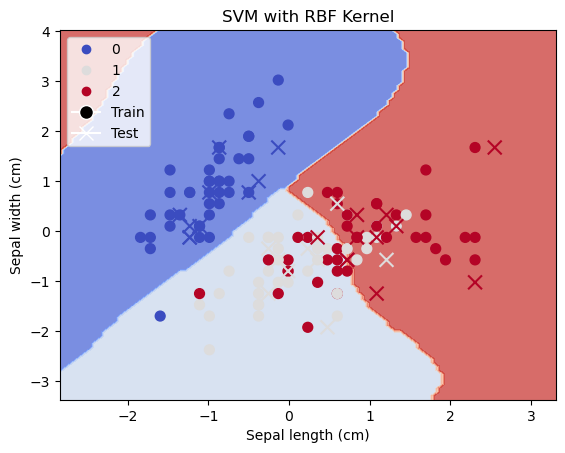


Model training time: 0.0014 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.88      0.78      0.82         9
           2       0.83      0.91      0.87        11

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


Accuracy on test set: 0.9

Saving plot to /Users/jduffy0121/Repos/quantum_computing/applications/plots/svm_linear_c1.png...


<Figure size 1000x600 with 0 Axes>

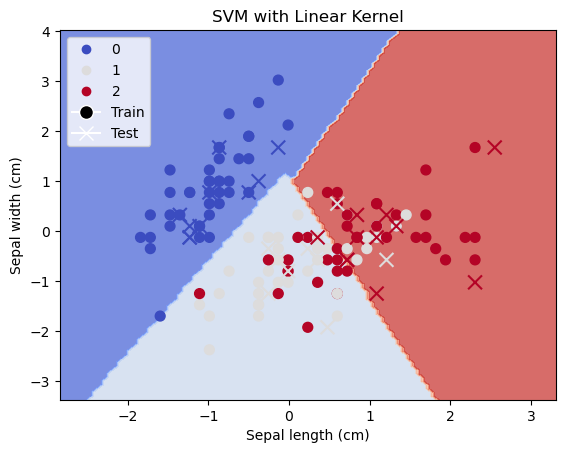


Model training time: 0.0007 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.47      1.00      0.64         9
           2       1.00      0.27      0.43        11

    accuracy                           0.67        30
   macro avg       0.82      0.69      0.65        30
weighted avg       0.84      0.67      0.65        30


Accuracy on test set: 0.6666666666666666

Saving plot to /Users/jduffy0121/Repos/quantum_computing/applications/plots/svm_poly_c1.png...


<Figure size 1000x600 with 0 Axes>

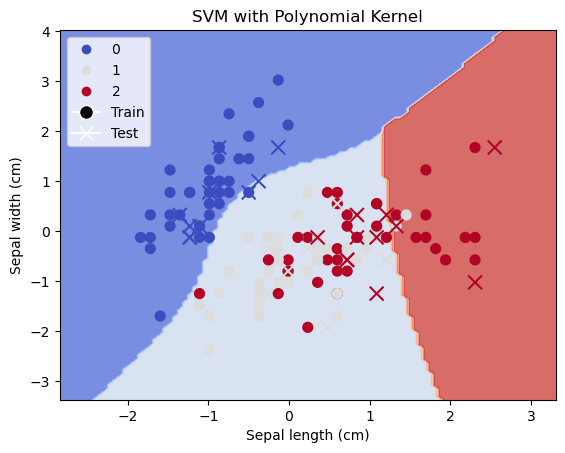


Model training time: 0.0007 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.67      0.44      0.53         9
           2       0.64      0.82      0.72        11

    accuracy                           0.77        30
   macro avg       0.77      0.75      0.75        30
weighted avg       0.77      0.77      0.76        30


Accuracy on test set: 0.7666666666666667

Saving plot to /Users/jduffy0121/Repos/quantum_computing/applications/plots/svm_sigmoid_c1.png...


<Figure size 1000x600 with 0 Axes>

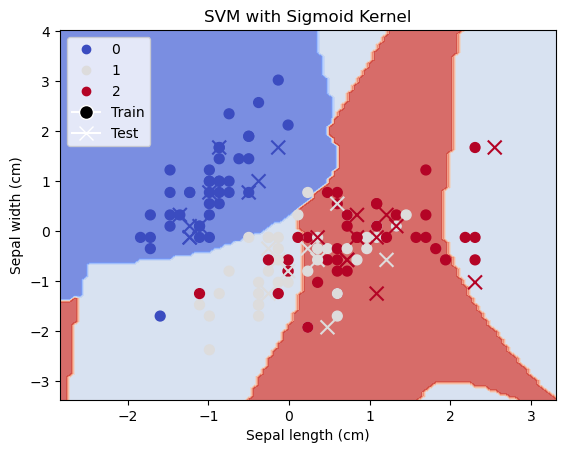

In [10]:
for kernel in params['kernel']:
  for c in params['C']:
    if kernel not in ['rbf','linear', 'poly', 'sigmoid']:
      print(f"Skipping invalid kernel: {kernel}")
      continue
    if not isinstance(c, (float, int)):
      print(f"Skipping invalid C: {c}")
      continue
    run_svm_experiment(kernel=kernel,
                       c = c,
                       X_train_scaled=X_train_scaled,
                       X_test_scaled=X_test_scaled,
                       y_train=y_train,
                       y_test=y_test)

# Quantum Implementation

Text

## References

Text